In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
GPU = 0
CIFAR_10_PATH = './CIFAR10' 
device = torch.device('cuda:'+str(GPU) if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose(
    [transforms.Resize((230,230)),
     transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ]
    )

# training data
train_dataset = datasets.CIFAR10(root=CIFAR_10_PATH, train=True, 
                            download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                         shuffle=True, num_workers=4)

# testing data
test_dataset = datasets.CIFAR10(root=CIFAR_10_PATH, train=False,
                           download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                             shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# initiate the network
net = models.squeezenet1_1(pretrained=True).to(device)
opt = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.001)
loss_fcn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [0]:
def laber_helper(step, y_true, y_pred, label, out):
    if(step==0):
        y_true = label
        y_pred = out
    else:
        y_true = torch.cat((y_true, label), 0)
        y_pred = torch.cat((y_pred, out))

    return y_true, y_pred    

In [0]:
# Train the model, epoch = 50
train_accuracy = []
test_accuracy = []

for epoch in tqdm(range(50)):
    print('Current epoch: %d' %epoch)
    y_true = []
    y_pred = []
    test_y_true = []
    test_y_pred = []

    # training the model
    net.train()
    for step, (img, label) in enumerate(dataloader):
        img = img.float().to(device)
        label = label.long().to(device)
        opt.zero_grad()
        out = net(img)
        loss = loss_fcn(out, label)

        y_true, y_pred = laber_helper(step, y_true, y_pred, label.cpu().detach(), out.cpu().detach())

        loss.backward()
        opt.step()        
        
    scheduler.step()
    acc = float(torch.sum(torch.max(y_pred, 1)[1]==y_true))/ float(len(y_pred))        
    train_accuracy.append(acc)
    
    # test the model for every epoch
    net.eval()
    with torch.no_grad():
        for step, (img, label) in enumerate(test_dataloader):
            img = img.float().to(device)
            label = label.long().to(device)
            out = net(img)

            test_y_true, test_y_pred = laber_helper(step, test_y_true, test_y_pred, label.cpu().detach(), out.cpu().detach())

    test_acc = float(torch.sum(torch.max(test_y_pred, 1)[1]==test_y_true))/ float(len(test_y_pred))
    test_accuracy.append(test_acc)
    print(' -Train Accuracy %.4f  -Test Accuracy %.4f' %(acc, test_acc))
    

  0%|          | 0/50 [00:00<?, ?it/s]

Current epoch: 0


  2%|▏         | 1/50 [02:49<2:18:32, 169.65s/it]

 -Train Accuracy 0.6126  -Test Accuracy 0.7750
Current epoch: 1


  4%|▍         | 2/50 [05:36<2:14:58, 168.71s/it]

 -Train Accuracy 0.7967  -Test Accuracy 0.8251
Current epoch: 2


  6%|▌         | 3/50 [08:24<2:12:01, 168.55s/it]

 -Train Accuracy 0.8385  -Test Accuracy 0.8482
Current epoch: 3


  8%|▊         | 4/50 [11:11<2:08:54, 168.14s/it]

 -Train Accuracy 0.8582  -Test Accuracy 0.8614
Current epoch: 4


 10%|█         | 5/50 [13:57<2:05:32, 167.39s/it]

 -Train Accuracy 0.8745  -Test Accuracy 0.8782
Current epoch: 5


 12%|█▏        | 6/50 [16:45<2:02:55, 167.63s/it]

 -Train Accuracy 0.8840  -Test Accuracy 0.8665
Current epoch: 6


 14%|█▍        | 7/50 [19:34<2:00:21, 167.93s/it]

 -Train Accuracy 0.8906  -Test Accuracy 0.8871
Current epoch: 7


 16%|█▌        | 8/50 [22:20<1:57:09, 167.36s/it]

 -Train Accuracy 0.8994  -Test Accuracy 0.8917
Current epoch: 8


 18%|█▊        | 9/50 [25:07<1:54:18, 167.27s/it]

 -Train Accuracy 0.9045  -Test Accuracy 0.8961
Current epoch: 9


 20%|██        | 10/50 [27:55<1:51:45, 167.65s/it]

 -Train Accuracy 0.9074  -Test Accuracy 0.8920
Current epoch: 10


 22%|██▏       | 11/50 [30:45<1:49:28, 168.43s/it]

 -Train Accuracy 0.9119  -Test Accuracy 0.8971
Current epoch: 11


 24%|██▍       | 12/50 [33:34<1:46:39, 168.40s/it]

 -Train Accuracy 0.9177  -Test Accuracy 0.9011
Current epoch: 12


 26%|██▌       | 13/50 [36:22<1:43:53, 168.48s/it]

 -Train Accuracy 0.9210  -Test Accuracy 0.9030
Current epoch: 13


 28%|██▊       | 14/50 [39:12<1:41:17, 168.82s/it]

 -Train Accuracy 0.9250  -Test Accuracy 0.9018
Current epoch: 14


 30%|███       | 15/50 [41:58<1:38:03, 168.09s/it]

 -Train Accuracy 0.9239  -Test Accuracy 0.9045
Current epoch: 15


 32%|███▏      | 16/50 [44:47<1:35:16, 168.12s/it]

 -Train Accuracy 0.9302  -Test Accuracy 0.9101
Current epoch: 16


 34%|███▍      | 17/50 [47:34<1:32:22, 167.96s/it]

 -Train Accuracy 0.9332  -Test Accuracy 0.9104
Current epoch: 17


 36%|███▌      | 18/50 [50:20<1:29:15, 167.36s/it]

 -Train Accuracy 0.9347  -Test Accuracy 0.8977
Current epoch: 18


 38%|███▊      | 19/50 [53:08<1:26:29, 167.41s/it]

 -Train Accuracy 0.9361  -Test Accuracy 0.8984
Current epoch: 19


 40%|████      | 20/50 [55:56<1:23:51, 167.71s/it]

 -Train Accuracy 0.9359  -Test Accuracy 0.9115
Current epoch: 20


 42%|████▏     | 21/50 [58:44<1:21:06, 167.83s/it]

 -Train Accuracy 0.9414  -Test Accuracy 0.9077
Current epoch: 21


 44%|████▍     | 22/50 [1:01:30<1:17:58, 167.09s/it]

 -Train Accuracy 0.9415  -Test Accuracy 0.9119
Current epoch: 22


 46%|████▌     | 23/50 [1:04:20<1:15:36, 168.01s/it]

 -Train Accuracy 0.9420  -Test Accuracy 0.9113
Current epoch: 23


 48%|████▊     | 24/50 [1:07:08<1:12:51, 168.13s/it]

 -Train Accuracy 0.9463  -Test Accuracy 0.9134
Current epoch: 24


 50%|█████     | 25/50 [1:09:54<1:09:46, 167.44s/it]

 -Train Accuracy 0.9464  -Test Accuracy 0.9159
Current epoch: 25


 52%|█████▏    | 26/50 [1:12:41<1:06:58, 167.42s/it]

 -Train Accuracy 0.9480  -Test Accuracy 0.9169
Current epoch: 26


 54%|█████▍    | 27/50 [1:15:28<1:04:03, 167.09s/it]

 -Train Accuracy 0.9496  -Test Accuracy 0.9049
Current epoch: 27


 56%|█████▌    | 28/50 [1:18:14<1:01:11, 166.89s/it]

 -Train Accuracy 0.9494  -Test Accuracy 0.9097
Current epoch: 28


 58%|█████▊    | 29/50 [1:21:01<58:25, 166.91s/it]  

 -Train Accuracy 0.9538  -Test Accuracy 0.9117
Current epoch: 29


 60%|██████    | 30/50 [1:23:49<55:41, 167.09s/it]

 -Train Accuracy 0.9507  -Test Accuracy 0.9144
Current epoch: 30


 62%|██████▏   | 31/50 [1:26:36<52:58, 167.30s/it]

 -Train Accuracy 0.9549  -Test Accuracy 0.9167
Current epoch: 31


 64%|██████▍   | 32/50 [1:29:23<50:06, 167.04s/it]

 -Train Accuracy 0.9576  -Test Accuracy 0.9102
Current epoch: 32


 66%|██████▌   | 33/50 [1:32:15<47:44, 168.52s/it]

 -Train Accuracy 0.9555  -Test Accuracy 0.9168
Current epoch: 33


 68%|██████▊   | 34/50 [1:35:02<44:48, 168.06s/it]

 -Train Accuracy 0.9584  -Test Accuracy 0.9107
Current epoch: 34


 70%|███████   | 35/50 [1:37:47<41:50, 167.37s/it]

 -Train Accuracy 0.9586  -Test Accuracy 0.9163
Current epoch: 35


 72%|███████▏  | 36/50 [1:40:36<39:07, 167.65s/it]

 -Train Accuracy 0.9607  -Test Accuracy 0.9165
Current epoch: 36


 74%|███████▍  | 37/50 [1:43:24<36:21, 167.84s/it]

 -Train Accuracy 0.9598  -Test Accuracy 0.9075
Current epoch: 37


 76%|███████▌  | 38/50 [1:46:11<33:29, 167.44s/it]

 -Train Accuracy 0.9621  -Test Accuracy 0.9168
Current epoch: 38


 78%|███████▊  | 39/50 [1:48:58<30:42, 167.54s/it]

 -Train Accuracy 0.9620  -Test Accuracy 0.9141
Current epoch: 39


 80%|████████  | 40/50 [1:51:51<28:10, 169.02s/it]

 -Train Accuracy 0.9634  -Test Accuracy 0.9156
Current epoch: 40


 82%|████████▏ | 41/50 [1:54:41<25:23, 169.26s/it]

 -Train Accuracy 0.9644  -Test Accuracy 0.9159
Current epoch: 41


 84%|████████▍ | 42/50 [1:57:33<22:42, 170.29s/it]

 -Train Accuracy 0.9662  -Test Accuracy 0.9161
Current epoch: 42


 86%|████████▌ | 43/50 [2:00:25<19:54, 170.61s/it]

 -Train Accuracy 0.9650  -Test Accuracy 0.9144
Current epoch: 43


 88%|████████▊ | 44/50 [2:03:11<16:55, 169.25s/it]

 -Train Accuracy 0.9663  -Test Accuracy 0.9163
Current epoch: 44


 90%|█████████ | 45/50 [2:05:56<14:00, 168.15s/it]

 -Train Accuracy 0.9687  -Test Accuracy 0.9209
Current epoch: 45


 92%|█████████▏| 46/50 [2:08:44<11:12, 168.03s/it]

 -Train Accuracy 0.9670  -Test Accuracy 0.9140
Current epoch: 46


 94%|█████████▍| 47/50 [2:11:33<08:25, 168.37s/it]

 -Train Accuracy 0.9694  -Test Accuracy 0.9192
Current epoch: 47


 96%|█████████▌| 48/50 [2:14:23<05:37, 168.77s/it]

 -Train Accuracy 0.9683  -Test Accuracy 0.9201
Current epoch: 48


 98%|█████████▊| 49/50 [2:17:12<02:48, 168.80s/it]

 -Train Accuracy 0.9701  -Test Accuracy 0.9146
Current epoch: 49


100%|██████████| 50/50 [2:19:59<00:00, 167.98s/it]

 -Train Accuracy 0.9707  -Test Accuracy 0.9161


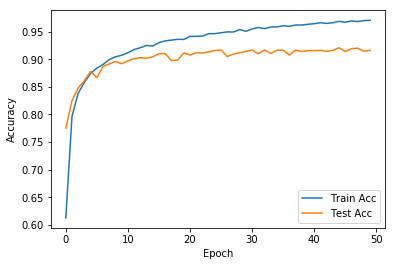

In [0]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.legend(('Train Acc', 'Test Acc'))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')